In [2]:
import cv2
import os
import numpy as np
import skimage
from skimage import io, transform, color, filters, data, morphology, measure
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def load_images_from_folder(folder):
    images = []
    images_name = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            images_name.append(filename)
    
    images_df = pd.DataFrame({"name": images_name,
                             "image": images})
    #print(images_df)
    return images_df

def display(np_image):
    """
    This is a display function that we have added to show numpy images at full size
    If you pass in an image with 3 channels, it will be displayed in RGB
    If you passn in an image with 1 channel, it will be displayed in grayscale
    """
    dpi = matplotlib.rcParams['figure.dpi']
    if len(np_image.shape) == 3:
        height, width, depth = np_image.shape
    else:
        height, width = np_image.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')
    
    # Display the image in either RGB or grayscale (depending on the amount of dimensions)
    if (len(np_image.shape) >= 3):
        ax.imshow(np_image)
    else:
        ax.imshow(np_image, cmap='gray')

    plt.show()

all_images_df = load_images_from_folder('../dataset-images/dataset1')

#print(len(list_images))
#print(list_images[0])
#print(list_images_name)
print('----------done---------')

----------done---------


In [3]:


#display(list_images[0])
#zipcode = list_images[0]
#zipcode = zipcode *-1
#gray = color.rgb2gray(zipcode)#
#display(gray)
#thresh = filters.threshold_otsu(gray)
#binary = gray > thresh
#display(binary)
#label_image = measure.label(binary)
#display(label_image)

#props = measure.regionprops_table(label_image, properties=['label', 'area', 'bbox', 'bbox_area', 'perimeter', 
#                                                           'convex_area', 'eccentricity', 'equivalent_diameter', 
#                                                           'euler_number', 'extent', 'feret_diameter_max', 'filled_area',
#                                                           'orientation', 'perimeter_crofton', 'solidity'])
#data = pd.DataFrame(props)

#print(data)

#for region in measure.regionprops_table(label_image):
 #   region
    #print(region.properties)
    #print(region.area, ' // ', region.centroid, ' // ', region.perimeter, ' // ', region.filled_area)

df = None
error_counts = 0

image_properties = ['label', 'area', 'bbox', 'bbox_area', 'perimeter', 
            'convex_area', 'eccentricity', 'equivalent_diameter', 
            'extent', 'feret_diameter_max', 'filled_area',
            'perimeter_crofton', 'solidity']

def initialize_image(image, image_name):
    zipcode = image
    zipcode = zipcode *-1
    gray = color.rgb2gray(zipcode)
    thresh = filters.threshold_otsu(gray)
    binary = gray > thresh
    #display(binary)
    
    # remove the white small spots/dots
    binary = morphology.binary_opening(binary)
    #display(binary)
    
    # make the white zip numbers thicker
    binary = morphology.binary_dilation(binary)
    #display(binary)
    
    # some numbers may have holes in it. That could seperate the number in 2 different labels. with closing the gap will be closed
    binary = morphology.binary_closing(binary)
    #display(binary)
    
    # return number back to its original state before it was made thicker. make the numbers thinner
    binary = morphology.binary_erosion(binary)
    #display(binary)
    # return_num=True, connectivity=None
    #print(binary)
    label_image, total_labels = measure.label(binary, return_num=True)
    #display(label_image)
    global image_properties
    props = measure.regionprops_table(label_image, properties=image_properties)
    tmp_df = pd.DataFrame(props)
    
    # filter out labels that have too small areas. these labels are small dots that could not be filled with the opening function
    tmp_df = tmp_df.query('area > 50')
    #print(tmp_df)
    zip_numbers = list(image_name)[:4]
    if len(tmp_df.index) == 4:
        #print('-----------------')
        #print(total_labels)
        tmp_df.insert(0, 'zip_numbers', zip_numbers)
    else:
        return None
        
    return tmp_df

print('----------done---------')

----------done---------


In [9]:
result = pd.DataFrame()

for i in range(0, len(all_images_df.index)):
    image_name = all_images_df.iloc[i,0]
    image = all_images_df.iloc[i,1]
    tmp_result = initialize_image(image, image_name)
    result = pd.concat([result, tmp_result])

result.reset_index(inplace=True)
result.drop(columns=['index', 'label'], inplace=True)
result

,zip_numbers,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox_area,perimeter,convex_area,eccentricity,equivalent_diameter,extent,feret_diameter_max,filled_area,perimeter_crofton,solidity
0,1,287,0,6,32,26,640,89.840620,395,0.815101,19.115955,0.448437,32.249031,287,87.855766,0.726582
1,0,296,0,38,32,58,640,143.781746,506,0.786829,19.413369,0.462500,32.756679,488,136.313643,0.584980
2,0,300,0,70,32,91,672,145.781746,518,0.796555,19.544100,0.446429,32.756679,497,138.209762,0.579151
3,0,346,0,101,32,123,704,151.781746,583,0.747489,20.989066,0.491477,32.984845,563,143.898118,0.593482
4,1,318,0,4,32,29,800,103.840620,502,0.920800,20.121883,0.397500,36.715120,318,101.128598,0.633466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2,345,0,102,32,124,704,120.225397,557,0.900438,20.958713,0.490057,35.777088,345,116.662340,0.619390
956,5,279,0,7,32,24,544,109.396970,469,0.936468,18.847648,0.512868,33.526109,279,106.396348,0.594883
957,3,312,0,38,32,59,672,122.953319,528,0.903071,19.931150,0.464286,33.241540,312,120.589331,0.590909
958,8,431,0,69,32,92,736,150.994949,563,0.776471,23.425760,0.585598,32.984845,519,140.470671,0.765542


In [6]:
#initialize_image(list_images[0], list_images_name[0])

#print('-------splitting train en test data------')
#train_images_df = all_images_df.sample(frac=0.9, random_state=25)
#print('-------80%------')
#test_images_df = all_images_df.drop(train_images_df.index)


#print(len(train_images_df.index))
#print(len(test_images_df.index))

#train_images_df.reset_index(inplace=True,drop=True)
#test_images_df.reset_index(inplace=True,drop=True)

#print('-------done------')

#all_images_df

-------splitting train en test data------
-------80%------
216
24
-------done------


,name,image
0,1000.png,"[[[241, 241, 241], [242, 242, 242], [244, 244,..."
1,1027.png,"[[[206, 206, 206], [211, 211, 211], [218, 218,..."
2,1029.png,"[[[82, 82, 82], [83, 83, 83], [84, 84, 84], [8..."
3,1036.png,"[[[241, 241, 241], [246, 246, 246], [243, 243,..."
4,1053.png,"[[[241, 241, 241], [243, 243, 243], [243, 243,..."
...,...,...
235,5264.png,"[[[228, 228, 228], [227, 227, 227], [224, 224,..."
236,5339.png,"[[[70, 70, 70], [71, 71, 71], [67, 67, 67], [7..."
237,5377.png,"[[[243, 243, 243], [236, 236, 236], [243, 243,..."
238,5382.png,"[[[214, 214, 214], [222, 222, 222], [206, 206,..."


In [5]:
#for i in range(0, len(train_images_df.index)):
#    if df is not None:
#        result = initialize_image(train_images_df.iloc[i, 1], train_images_df.iloc[i, 0])
#        if result is not None:
#            df = pd.concat([df, result], ignore_index=True)
#        else:
#            error_counts = error_counts + 1
#    else:
#        df = initialize_image(train_images_df.iloc[i, 1], train_images_df.iloc[i, 0])

#initialize_image(list_images[72], list_images_name[72])
#print('images with errors: ', error_counts)
#print('----------done---------')
#df

images with errors:  0
----------done---------


,zip_numbers,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox_area,perimeter,convex_area,eccentricity,equivalent_diameter,extent,feret_diameter_max,filled_area,perimeter_crofton,solidity
0,1,1,315,0,8,32,23,480,89.254834,404,0.941683,20.026744,0.656250,33.241540,315,87.300406,0.779703
1,5,2,327,0,37,32,59,704,118.468037,535,0.847351,20.404640,0.464489,34.928498,327,114.996259,0.611215
2,5,3,314,0,70,32,90,640,128.367532,528,0.871407,19.994930,0.490625,32.984845,314,124.381569,0.594697
3,7,4,310,0,104,32,125,672,115.982756,469,0.890932,19.867165,0.461310,35.777088,310,112.640065,0.660981
4,1,1,308,0,5,32,26,672,98.083261,489,0.932264,19.802974,0.458333,33.837849,308,95.670280,0.629857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,9,4,386,0,101,32,123,704,129.296465,540,0.816422,22.169133,0.548295,33.241540,404,122.580735,0.714815
860,1,1,318,0,4,32,29,800,103.840620,502,0.920800,20.121883,0.397500,36.715120,318,101.128598,0.633466
861,0,2,289,0,38,32,58,640,145.225397,522,0.804942,19.182446,0.451562,33.241540,501,138.075009,0.553640
862,2,3,367,0,69,32,92,736,127.781746,542,0.895221,21.616635,0.498641,34.539832,367,123.826209,0.677122


In [24]:
result.describe(include="all")

,zip_numbers,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox_area,perimeter,convex_area,eccentricity,equivalent_diameter,extent,feret_diameter_max,filled_area,perimeter_crofton,solidity
count,864,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000
unique,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.503472,332.281250,0.003472,54.133102,31.995370,74.690972,657.684028,117.259459,494.259259,0.854239,20.534284,0.510878,33.543794,353.944444,113.165448,0.676698
std,NaN,1.121779,38.475808,0.058857,35.908950,0.067923,35.930319,74.627672,17.358544,53.711969,0.059644,1.190992,0.078593,1.260031,61.999844,15.745595,0.081272
min,NaN,1.000000,228.000000,0.000000,1.000000,31.000000,20.000000,352.000000,81.254834,272.000000,0.622461,17.038152,0.328125,31.064449,228.000000,79.715930,0.491071
25%,NaN,1.750000,301.000000,0.000000,27.250000,32.000000,47.750000,617.000000,105.296465,461.000000,0.818443,19.576647,0.457386,32.557641,311.000000,102.379852,0.618610
50%,NaN,3.000000,332.500000,0.000000,54.000000,32.000000,74.500000,640.000000,116.811183,497.000000,0.869382,20.575517,0.500000,33.241540,343.000000,113.330178,0.669109
75%,NaN,4.000000,358.000000,0.000000,81.000000,32.000000,101.500000,704.000000,129.306872,531.000000,0.897703,21.349936,0.546875,34.176015,383.000000,124.056246,0.720800


In [25]:
#pd.set_option('display.max_rows', None)
#df.query('zip_numbers == "0"')
result['zip_numbers'] = result['zip_numbers'].astype(int)
print('done')

done


In [26]:
X = result.iloc[:,1:17]
X

,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox_area,perimeter,convex_area,eccentricity,equivalent_diameter,extent,feret_diameter_max,filled_area,perimeter_crofton,solidity
0,1,315,0,8,32,23,480,89.254834,404,0.941683,20.026744,0.656250,33.241540,315,87.300406,0.779703
1,2,327,0,37,32,59,704,118.468037,535,0.847351,20.404640,0.464489,34.928498,327,114.996259,0.611215
2,3,314,0,70,32,90,640,128.367532,528,0.871407,19.994930,0.490625,32.984845,314,124.381569,0.594697
3,4,310,0,104,32,125,672,115.982756,469,0.890932,19.867165,0.461310,35.777088,310,112.640065,0.660981
4,1,308,0,5,32,26,672,98.083261,489,0.932264,19.802974,0.458333,33.837849,308,95.670280,0.629857
5,2,314,0,39,32,61,704,122.746212,548,0.900017,19.994930,0.446023,34.928498,314,119.248573,0.572993
6,3,358,0,70,32,91,672,107.982756,527,0.863306,21.349936,0.532738,33.837849,358,105.055589,0.679317
7,4,342,0,104,32,124,640,111.195959,439,0.843453,20.867389,0.534375,32.984845,355,105.420380,0.779043
8,1,352,0,4,32,26,704,98.811183,467,0.795305,21.170270,0.500000,32.557641,352,96.360393,0.753747
9,2,416,0,36,32,60,768,120.024387,547,0.867094,23.014510,0.541667,33.241540,437,113.790254,0.760512


In [27]:
Y = result.iloc[:,0]
Y

0      1
1      5
2      5
3      7
4      1
5      2
6      7
7      6
8      4
9      8
10     4
11     8
12     2
13     0
14     9
15     6
16     3
17     7
18     0
19     0
20     1
21     9
22     9
23     8
24     1
25     0
26     5
27     3
28     3
29     9
30     7
31     6
32     2
33     7
34     5
35     3
36     5
37     2
38     2
39     9
40     1
41     1
42     0
43     7
44     1
45     1
46     8
47     8
48     3
49     3
50     4
51     1
52     3
53     7
54     0
55     3
56     1
57     3
58     9
59     1
60     5
61     1
62     6
63     1
64     1
65     9
66     4
67     3
68     3
69     2
70     9
71     5
72     4
73     6
74     1
75     7
76     4
77     9
78     9
79     9
80     4
81     3
82     0
83     4
84     4
85     7
86     3
87     6
88     4
89     9
90     6
91     1
92     3
93     5
94     7
95     9
96     3
97     1
98     4
99     5
100    2
101    8
102    0
103    3
104    4
105    9
106    3
107    3
108    1
109    3
110    3
1

In [28]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                 Specs        Score
13         filled_area  5379.658641
3               bbox-1  3290.397583
5               bbox-3  2402.858129
6            bbox_area  2261.283252
8          convex_area  2180.201961
7            perimeter  1250.508052
14   perimeter_crofton  1041.927567
1                 area   340.010032
0                label    68.799108
12  feret_diameter_max    16.392734


In [29]:
# we used the selectK to filter the 10 best features from the dataset. Unvariate selection method

[0.02547333 0.04360812 0.00135835 0.04704913 0.00133873 0.04847357
 0.06393536 0.10536641 0.07273539 0.13871876 0.04284711 0.0620736
 0.09153521 0.09383251 0.09084403 0.0708104 ]


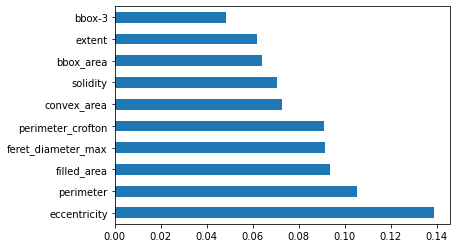

In [30]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,Y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [31]:
# Feature importance method. This method adds the eccentricity as an interesting feature.
result

,zip_numbers,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox_area,perimeter,convex_area,eccentricity,equivalent_diameter,extent,feret_diameter_max,filled_area,perimeter_crofton,solidity
0,1,1,315,0,8,32,23,480,89.254834,404,0.941683,20.026744,0.656250,33.241540,315,87.300406,0.779703
1,5,2,327,0,37,32,59,704,118.468037,535,0.847351,20.404640,0.464489,34.928498,327,114.996259,0.611215
2,5,3,314,0,70,32,90,640,128.367532,528,0.871407,19.994930,0.490625,32.984845,314,124.381569,0.594697
3,7,4,310,0,104,32,125,672,115.982756,469,0.890932,19.867165,0.461310,35.777088,310,112.640065,0.660981
4,1,1,308,0,5,32,26,672,98.083261,489,0.932264,19.802974,0.458333,33.837849,308,95.670280,0.629857
5,2,2,314,0,39,32,61,704,122.746212,548,0.900017,19.994930,0.446023,34.928498,314,119.248573,0.572993
6,7,3,358,0,70,32,91,672,107.982756,527,0.863306,21.349936,0.532738,33.837849,358,105.055589,0.679317
7,6,4,342,0,104,32,124,640,111.195959,439,0.843453,20.867389,0.534375,32.984845,355,105.420380,0.779043
8,4,1,352,0,4,32,26,704,98.811183,467,0.795305,21.170270,0.500000,32.557641,352,96.360393,0.753747
9,8,2,416,0,36,32,60,768,120.024387,547,0.867094,23.014510,0.541667,33.241540,437,113.790254,0.760512


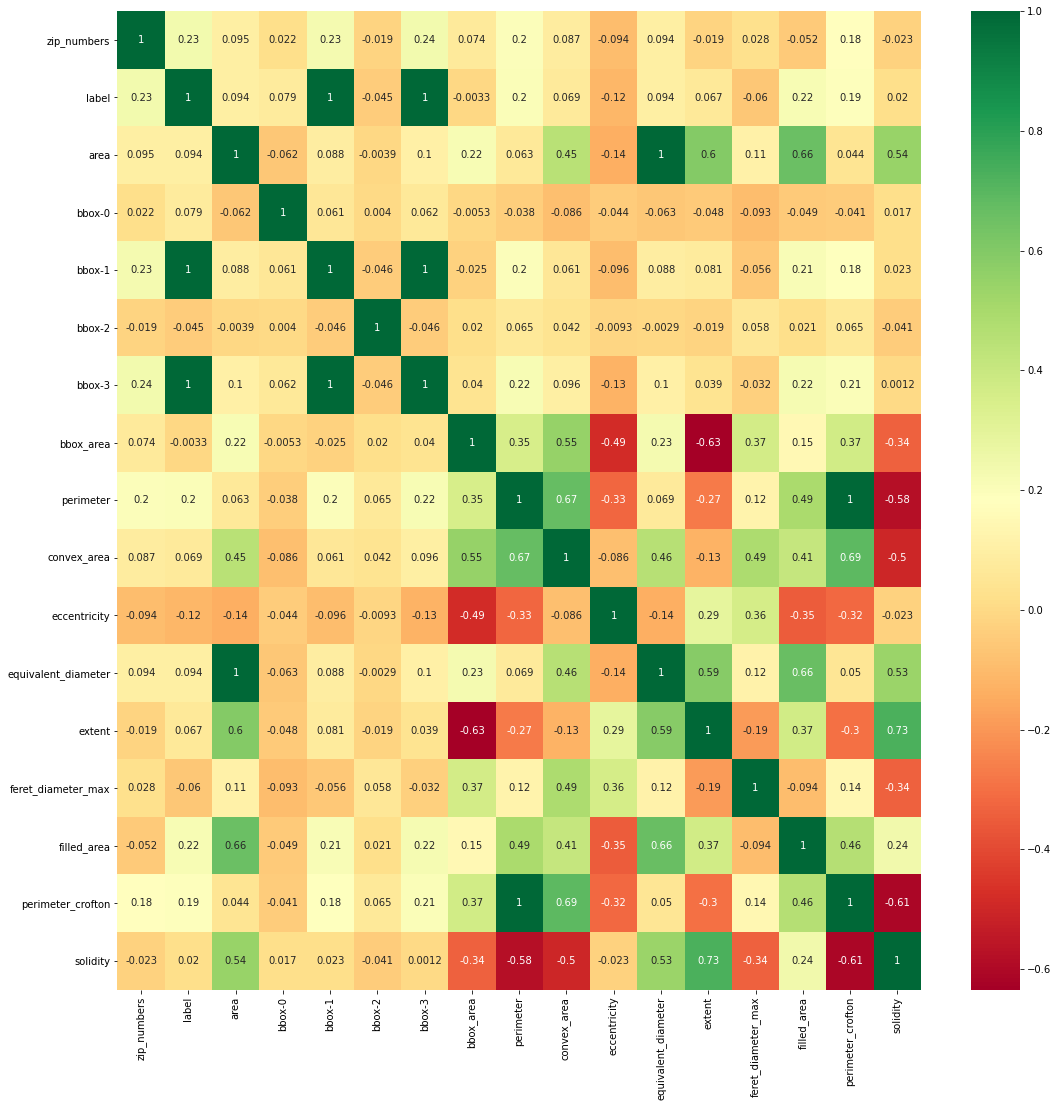

In [32]:
import seaborn as sns

#get correlations of each features in dataset
corrmat = result.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(18,18))
#plot heat map
g=sns.heatmap(result[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [33]:
features = ['filled_area', 'perimeter', 'perimeter_crofton', 'eccentricity', 'bbox-1', 'solidity', 'extent']
featuresZip = ['zip_numbers', 'filled_area', 'perimeter', 'perimeter_crofton', 'eccentricity', 'bbox-1', 'solidity', 'extent']
selected_features = result.loc[:,featuresZip]
selected_features

,zip_numbers,filled_area,perimeter,perimeter_crofton,eccentricity,bbox-1,solidity,extent
0,1,315,89.254834,87.300406,0.941683,8,0.779703,0.656250
1,5,327,118.468037,114.996259,0.847351,37,0.611215,0.464489
2,5,314,128.367532,124.381569,0.871407,70,0.594697,0.490625
3,7,310,115.982756,112.640065,0.890932,104,0.660981,0.461310
4,1,308,98.083261,95.670280,0.932264,5,0.629857,0.458333
5,2,314,122.746212,119.248573,0.900017,39,0.572993,0.446023
6,7,358,107.982756,105.055589,0.863306,70,0.679317,0.532738
7,6,355,111.195959,105.420380,0.843453,104,0.779043,0.534375
8,4,352,98.811183,96.360393,0.795305,4,0.753747,0.500000
9,8,437,120.024387,113.790254,0.867094,36,0.760512,0.541667


In [34]:
selected_features.describe()

,zip_numbers,filled_area,perimeter,perimeter_crofton,eccentricity,bbox-1,solidity,extent
count,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000
mean,3.972222,353.944444,117.259459,113.165448,0.854239,54.133102,0.676698,0.510878
std,2.753136,61.999844,17.358544,15.745595,0.059644,35.908950,0.081272,0.078593
min,0.000000,228.000000,81.254834,79.715930,0.622461,1.000000,0.491071,0.328125
25%,2.000000,311.000000,105.296465,102.379852,0.818443,27.250000,0.618610,0.457386
50%,4.000000,343.000000,116.811183,113.330178,0.869382,54.000000,0.669109,0.500000
75%,6.000000,383.000000,129.306872,124.056246,0.897703,81.000000,0.720800,0.546875
max,9.000000,579.000000,167.480231,156.099698,0.966171,106.000000,0.953811,0.829327


In [ ]:
from sklearn.model_selection import train_test_split

def splitTrainTest(result):
    # Split data into 50% train and 50% test subsets
    global features
    X_train, X_test, y_train, y_test = train_test_split(
        result[features], result['number'], test_size=0.3, random_state=0)
    
    return X_train, X_test, y_train, y_test

#print('-------splitting train en test data------')
#train_data = result.sample(frac=0.9, random_state=25)
#print('-------50%------')
#test_data = result.drop(train_data.index)

def preprocess(X_train, X_test):
    print('-----Start preprocc----------')
    global features
    X_train[features] = scalerB.fit_transform(X_train[features].to_numpy())
    X_test[features] = scalerB.transform(X_test[features].to_numpy())
    print('---------Preprocess Done--------')
    return X_train, X_test

In [35]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scalerA = StandardScaler()
scalerB = MinMaxScaler()

x_train, x_test, y_train, y_test = splitTrainTest(result)
print('-------splitting train en test data------')
#train_data = selected_features.sample(frac=0.9, random_state=25)
print('-------50%------')
#test_data = selected_features.drop(train_data.index)

# 'filled_area', 'bbox-3', 'perimeter', 'perimeter_crofton', 'bbox-1', 'bbox_area', 'convex_area' -> 0.58
# 'filled_area', 'perimeter', 'perimeter_crofton', 'eccentricity', 'bbox-1', 'solidity', 'bbox-3' -> 0.66
# 'filled_area', 'perimeter', 'perimeter_crofton', 'eccentricity', 'bbox-1', 'solidity', 'extent' -> 0.69/0.7
# 'filled_area', 'perimeter', 'perimeter_crofton', 'eccentricity', 'area', 'solidity', 'extent' ->
x_train = scalerB.fit_transform(x_train.to_numpy())
x_test = scalerB.transform(x_test.to_numpy())
#selected_features

-------splitting train en test data------
-------50%------


,zip_numbers,filled_area,perimeter,perimeter_crofton,eccentricity,bbox-1,solidity,extent
0,1,315,89.254834,87.300406,0.941683,8,0.779703,0.656250
1,5,327,118.468037,114.996259,0.847351,37,0.611215,0.464489
2,5,314,128.367532,124.381569,0.871407,70,0.594697,0.490625
3,7,310,115.982756,112.640065,0.890932,104,0.660981,0.461310
4,1,308,98.083261,95.670280,0.932264,5,0.629857,0.458333
5,2,314,122.746212,119.248573,0.900017,39,0.572993,0.446023
6,7,358,107.982756,105.055589,0.863306,70,0.679317,0.532738
7,6,355,111.195959,105.420380,0.843453,104,0.779043,0.534375
8,4,352,98.811183,96.360393,0.795305,4,0.753747,0.500000
9,8,437,120.024387,113.790254,0.867094,36,0.760512,0.541667


In [36]:
#y_test = test_data.loc[:,['zip_numbers']]
#x_test = test_data.iloc[:,[1, 2, 3, 4, 5, 6, 7]]


#y_train = train_data.loc[:,['zip_numbers']]
#x_train = train_data.iloc[:,[1, 2, 3, 4, 5, 6, 7]]
#x_train

,filled_area,perimeter,perimeter_crofton,eccentricity,bbox-1,solidity,extent
162,0.441595,0.125583,0.134400,0.802085,0.657143,0.696055,0.602171
195,0.427350,0.625583,0.669506,0.697550,0.942857,0.275720,0.327338
399,0.113960,0.304832,0.326235,0.577753,0.961905,0.351358,0.180815
670,0.242165,0.411200,0.440071,0.315763,0.685714,0.283518,0.193828
505,0.102564,0.452444,0.484211,0.432975,0.342857,0.268646,0.093525
209,0.307692,0.577544,0.618095,0.753864,0.371429,0.173655,0.342926
398,0.193732,0.372769,0.398942,0.867760,0.676190,0.353970,0.575699
37,0.173789,0.414014,0.443082,0.840200,0.352381,0.200474,0.203380
187,0.387464,0.523195,0.559929,0.779547,0.971429,0.272027,0.290967
855,0.065527,0.178013,0.193082,0.744172,0.952381,0.377558,0.214762


In [37]:
from sklearn.neighbors import KNeighborsClassifier
train_samples = len(x_train)
test_samples = len (x_test)
neigh = KNeighborsClassifier(n_neighbors=6, weights='distance', metric='chebyshev')
neigh.fit(x_train, y_train.to_numpy().reshape(train_samples))

score = neigh.score(x_test, y_test.to_numpy().reshape(test_samples))
print("Score: ", score)




Score:  0.6976744186046512


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def knn_fit_score(X_train, X_test, y_train, y_test):
    train_samples = len(X_train)
    test_samples = len (X_test)
    neigh = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan')
    neigh.fit(X_train, y_train.to_numpy().reshape(train_samples))

    score = neigh.score(X_test, y_test.to_numpy().reshape(test_samples))
    return score

def kfolding_knn(dataset):
    kf = KFold(n_splits=5, shuffle=True)
    features = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
    X_training = dataset[features]
    y_training = dataset['number']
    k = 1
    for train_index, test_index in kf.split(X_training, y_training):
        
        X_train, X_test = X_training.loc[train_index,:], X_training.loc[test_index,:]
        y_train, y_test = y_training.loc[train_index], y_training.loc[test_index]
        X_train, X_test = preprocess(X_train, X_test)
        
        score = knn_fit_score(X_train, X_test, y_train, y_test)
        print("[fold {0}], score: {1:.5f}".
          format(k, score))
        k = k + 1
        
def searchHyperParams_knn(result):
    print('--------start searching params--------')
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    print('--------splitted train test----------')
    grid_params = {
        'n_neighbors' : [3,5,11,14,19],
        'weights' : ['uniform', 'distance'],
        'metric' : ['euclidean', 'manhattan', 'chebyshev']
    }

    gs = GridSearchCV(
        KNeighborsClassifier(),
        grid_params,
        verbose = 1,
        cv = 3,
        n_jobs = -1
    )
    print('---------grid search started---------')
    gs_results = gs.fit(X_train, y_train)

    print('--------Done--------')
    print('best score:')
    print(gs_results.best_score_)
    print('best estimator:')
    print(gs_results.best_estimator_)
    print('best params:')
    print(gs_results.best_params_)
    
def gaussian_nb_fit_score(result):
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)

    score = gnb.score(X_test, y_test)
    print(score)
    
def searchHyperParams_svc(result):
    print('--------start searching params--------')
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    print('--------splitted train test----------')
    grid_params = {
        'C': [0.1,1, 10, 100],
        'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': [1,0.1,0.01,0.001]
    }

    gs = GridSearchCV(
        SVC(),
        grid_params,
        verbose = 1,
        cv = 3,
        n_jobs = -1
    )
    print('---------grid search started---------')
    gs_results = gs.fit(X_train, y_train)

    print('--------Done--------')
    print('best score:')
    print(gs_results.best_score_)
    print('best estimator:')
    print(gs_results.best_estimator_)
    print('best params:')
    print(gs_results.best_params_)
    
def searchHyperParams_DT(result):
    print('--------start searching params--------')
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    print('--------splitted train test----------')
    grid_params = {
        'criterion': ['gini', 'entropy'],
        'splitter' : ['best', 'random'],
        'max_depth': [1,5,10,20,50,100,150,None],
        'min_samples_split': np.arange(2,5),
        'min_samples_leaf': np.arange(1,5),
        'min_weight_fraction_leaf': np.arange(0,0.5)
    }

    gs = GridSearchCV(
        DecisionTreeClassifier(),
        grid_params,
        verbose = 1,
        cv = 3,
        n_jobs = -1
    )
    print('---------grid search started---------')
    gs_results = gs.fit(X_train, y_train)

    print('--------Done--------')
    print('best score:')
    print(gs_results.best_score_)
    print('best estimator:')
    print(gs_results.best_estimator_)
    print('best params:')
    print(gs_results.best_params_)

def searchHyperParams_RC(result):
    print('--------start searching params--------')
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    print('--------splitted train test----------')
    grid_params = {
        'bootstrap': [True, False],
         'max_depth': [10, 20, 30, 40, None],
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400, 600, 800]
    }

    gs = GridSearchCV(
        RandomForestClassifier(),
        grid_params,
        verbose = 3,
        cv = 3,
        n_jobs = -1
    )
    print('---------grid search started---------')
    gs_results = gs.fit(X_train, y_train)

    print('--------Done--------')
    print('best score:')
    print(gs_results.best_score_)
    print('best estimator:')
    print(gs_results.best_estimator_)
    print('best params:')
    print(gs_results.best_params_)

In [38]:
total_images = len(test_images_df.index)
all_zipcodes = []
for i in range(0, total_images):
    imagename = test_images_df.iloc[i, 0]
    result = initialize_image(test_images_df.iloc[i, 1], test_images_df.iloc[i, 0])
    result.reset_index(inplace=True,drop=True)
    result['zip_numbers'] = result['zip_numbers'].astype(int)
    result_filtered = result.loc[:,featuresZip]
    result_filtered[features] = scalerB.transform(result_filtered[features].to_numpy())
    result_x = result_filtered.iloc[:,[1, 2, 3, 4, 5, 6, 7]]
    result_y = result_filtered.loc[:,['zip_numbers']]
    
    zipcode = []

    for ii in range(0, len(result_x.index)):
        predicted = neigh.predict(result_x.loc[ii].to_numpy().reshape(1,len(features)))
        #print('original: ', result_y.iloc[ii,[0]].to_numpy())
        #print('predicted: ', predicted)
        zipcode.insert(ii, predicted)
        
    all_zipcodes.append(zipcode)
    
for i in range(0, len(all_zipcodes)):
    print('predicted: ', all_zipcodes[i][0], all_zipcodes[i][1], all_zipcodes[i][2], all_zipcodes[i][3])
    print('original: ',  test_images_df.loc[i,['name']].to_numpy())
    
test_images_df.index

predicted:  [1] [0] [3] [7]
original:  ['1036.png']
predicted:  [1] [9] [0] [3]
original:  ['1807.png']
predicted:  [3] [0] [4] [4]
original:  ['2044.png']
predicted:  [2] [0] [5] [1]
original:  ['2051.png']
predicted:  [2] [2] [5] [6]
original:  ['2531.png']
predicted:  [2] [6] [0] [9]
original:  ['2608.png']
predicted:  [2] [1] [1] [7]
original:  ['2618.png']
predicted:  [2] [1] [8] [3]
original:  ['3182.png']
predicted:  [3] [1] [1] [6]
original:  ['3417.png']
predicted:  [3] [3] [7] [1]
original:  ['3521.png']
predicted:  [3] [7] [3] [6]
original:  ['3536.png']
predicted:  [2] [3] [0] [6]
original:  ['3591.png']
predicted:  [3] [7] [1] [1]
original:  ['3711.png']
predicted:  [3] [9] [9] [2]
original:  ['3921.png']
predicted:  [3] [3] [8] [9]
original:  ['3988.png']
predicted:  [4] [0] [0] [2]
original:  ['4005.png']
predicted:  [4] [1] [3] [9]
original:  ['4134.png']
predicted:  [4] [9] [0] [6]
original:  ['4206.png']
predicted:  [4] [2] [5] [2]
original:  ['4327.png']
predicted:  

RangeIndex(start=0, stop=24, step=1)